# Imports

In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data_utils
import torch.optim as optim
import seaborn as sns

## Train and test split

In [152]:
final = pd.read_excel("../data/processed/final.xlsx")
final = final[final.columns[2:]]
#divide data into train and test

train_ind = int(len(final)*0.8)
train = final[:train_ind]
test = final[train_ind:]

#train = train[train.columns[2:]]
train['overall'] = train['overall'].astype(np.float32)

<ipython-input-152-b506566f99d0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['overall'] = train['overall'].astype(np.float32)


# Linear Model

In [153]:
x = torch.tensor(train.drop('overall', axis = 1).values,dtype=torch.float32)
y = torch.tensor(train['overall'].values,dtype=torch.float32)

input_features = x.shape[1]
output_features = 1
learning_rate = 0.001
epochs = 10

# Time Series prediction

In [154]:
from statsmodels.tsa.stattools import grangercausalitytests

In [155]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=50
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [156]:
grangers_causation_matrix(train, variables = train.columns)

,overall_x,housing_x,apparel_x,transportation_x,medical_x,food_x,other_goods_x,education_x,recreation_x
overall_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0009,0.0001,0.0000
housing_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
apparel_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0006,0.0057,0.0000
transportation_y,0.0000,0.0000,0.0751,1.0000,0.0000,0.0000,0.0262,0.0000,0.0000
medical_y,0.0030,0.0018,0.0000,0.0000,1.0000,0.0009,0.1885,0.0000,0.0000
food_y,0.0000,0.0000,0.0000,0.0000,0.0090,1.0000,0.0015,0.0000,0.0001
other_goods_y,0.0000,0.0000,0.0012,0.0000,0.0004,0.0000,1.0000,0.0111,0.0000
education_y,0.0000,0.0000,0.0000,0.0486,0.0000,0.0374,0.0000,1.0000,0.0615
recreation_y,0.0009,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,1.0000


In [157]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(train)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
overall ::  229.91    > 179.5199  =>   True
housing ::  154.04    > 143.6691  =>   True
apparel ::  104.45    > 111.7797  =>   False
transportation ::  67.55     > 83.9383   =>   False
medical ::  44.34     > 60.0627   =>   False
food   ::  25.3      > 40.1749   =>   False
other_goods ::  10.87     > 24.2761   =>   False
education ::  3.93      > 12.3212   =>   False
recreation ::  0.1       > 4.1296    =>   False


In [158]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [159]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [160]:
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "overall" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.9105
 No. Lags Chosen       = 11
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.7845. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "housing" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.2096
 No. Lags Chosen       = 14
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.9374. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "apparel" 
    -----------------------------------------------
 Null Hypothesis: Data 

# LSTM Model

In [161]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

In [162]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(train)

In [213]:
pd.DataFrame(data_scaled)

,0,1,2,3,4,5,6,7,8
0,-1.659007,-1.721885,0.741837,0.428737,1.682723,-1.536882,-1.763277,0.633889,0.486940
1,-1.637739,-1.700905,1.041081,0.410847,1.682723,-1.540020,-1.746711,0.822924,0.486940
2,-1.620016,-1.686918,1.621966,0.446627,1.550334,-1.540020,-1.748217,0.728407,0.372807
3,-1.602292,-1.686918,1.692376,0.536077,1.285555,-1.508647,-1.743699,0.728407,0.829341
4,-1.591658,-1.679925,1.445940,0.661307,1.285555,-1.511784,-1.734663,0.539371,0.943474
...,...,...,...,...,...,...,...,...,...
254,1.454393,1.602967,0.394538,-1.074019,-0.435504,1.615367,1.514287,-1.918089,0.030406
255,1.494413,1.613632,0.454915,-0.769890,-0.832672,1.629014,1.519483,-2.012606,0.258673
256,1.528726,1.649334,0.452803,-1.020349,-0.700283,1.611665,1.533098,-2.012606,0.030406
257,1.556694,1.700700,0.050408,-1.002460,-0.170726,1.599807,1.548670,-2.012606,-0.083727


In [190]:
x = data_scaled[:,1:]
y = data_scaled[:,0]

#x = train.iloc[:,1:].values
#y = train.iloc[:,0].values

In [191]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=123,shuffle=False)

In [192]:
window_length = 10
num_features = 8
batch_size = 32

In [166]:
train_generator = TimeseriesGenerator(x_train,y_train,length=window_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test,y_test,length=window_length,sampling_rate=1,batch_size=batch_size)

In [167]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape = (window_length,num_features),return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [168]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 128)           70144     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 10, 128)           0         
                                                                 
 lstm_19 (LSTM)              (None, 10, 128)           131584    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 10, 128)           0         
                                                                 
 dropout_12 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_20 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_13 (Dropout)        (None, 64)               

In [169]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()]
              )
history = model.fit_generator(train_generator,epochs=50,validation_data=test_generator,shuffle=False,callbacks=[early_stopping])

Epoch 1/50


<ipython-input-169-60cc45f3e0af>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,epochs=50,validation_data=test_generator,shuffle=False,callbacks=[early_stopping])


7/7 [==============================] - 6s 219ms/step - loss: 0.5237 - mean_absolute_error: 0.6127 - val_loss: 0.8361 - val_mean_absolute_error: 0.9129
Epoch 2/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0527 - mean_absolute_error: 0.1823 - val_loss: 0.2270 - val_mean_absolute_error: 0.4682
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 0.0319 - mean_absolute_error: 0.1366 - val_loss: 0.2930 - val_mean_absolute_error: 0.5369
Epoch 4/50
7/7 [==============================] - 0s 26ms/step - loss: 0.0249 - mean_absolute_error: 0.1197 - val_loss: 0.2205 - val_mean_absolute_error: 0.4658
Epoch 5/50
7/7 [==============================] - 0s 25ms/step - loss: 0.0220 - mean_absolute_error: 0.1140 - val_loss: 0.2283 - val_mean_absolute_error: 0.4748
Epoch 6/50
7/7 [==============================] - 0s 24ms/step - loss: 0.0234 - mean_absolute_error: 0.1120 - val_loss: 0.0907 - val_mean_absolute_error: 0.2961
Epoch 7/50
7/7 [============================

In [170]:
model.evaluate_generator(test_generator,verbose=0)

<ipython-input-170-b08afc977308>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator,verbose=0)


[0.12391592562198639, 0.34812694787979126]

In [171]:
predictions = model.predict_generator(test_generator)

<ipython-input-171-9068eb02ed61>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


In [172]:
predictions.shape

(42, 1)

In [220]:
df_predictions = pd.concat([pd.DataFrame(predictions),pd.DataFrame(x_test[:,0:][window_length:])],axis=1)

In [222]:
rev_transform = scaler.inverse_transform(df_predictions)

In [271]:
df_final = train[predictions.shape[0]*-1:]

In [276]:
df_final['prediction'] = rev_transform[:,0]

<ipython-input-276-4fca173fe6cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['prediction'] = rev_transform[:,0]


In [277]:
df_final.head()

,overall,housing,apparel,transportation,medical,food,other_goods,education,recreation,Preds,prediction
217,232.166000,225.382,126.303,2.4,3.1,236.301,398.291,4.1,0.9,222.544430,222.544430
218,232.772995,225.643,128.279,0.1,3.1,236.332,399.265,4.1,0.6,223.066289,223.066289
219,232.531006,225.986,128.861,-2.0,2.7,236.841,400.239,4.1,0.6,223.635523,223.635523
220,232.945007,226.896,127.952,-0.6,2.2,236.526,399.966,4.0,0.8,223.846365,223.846365
221,233.503998,228.068,126.205,1.7,2.1,236.792,400.347,4.0,0.3,223.696177,223.696177


Text(0.5, 0, 'LSTM Overall vs prediction')

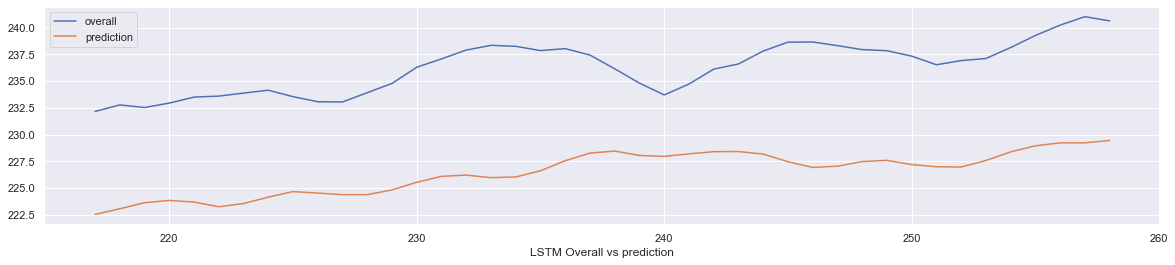

In [283]:
df_final[['overall','prediction']].plot()
sns.set(rc={'figure.figsize': (20, 4)})
plt.xlabel("LSTM Overall vs prediction")